In [11]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters

import tensorflow as tf
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D , Conv3D, Layer, MaxPooling2D, Dropout, Flatten, Dense, GRU, ConvLSTM2D, Input, BatchNormalization, TimeDistributed, MaxPooling3D, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from random import shuffle
from tensorflow.keras.regularizers import l2

# from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model, load_model


# import cv2
# import imageio
# import cv2

import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
# import IPython
# from six.moves import urllib
print(tf.__version__)
print(keras.__version__)
import pydicom
import re
import math
import random
# import bisect
np.random.seed(1234)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 1024
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 2
DIR = '/home/shared/nps/coatnp/'
NUM_SCANS = 8
NUM_CHANNELS = 1
INPUT_DIM = 256


2.8.1
2.8.0
Num GPUs Available:  1


In [12]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')
train_ids = pd.read_csv('train_df_upd.csv').drop(columns='Unnamed: 0')
test_ids = pd.read_csv('test_df_upd.csv').drop(columns='Unnamed: 0')
val_ids = pd.read_csv('val_df_upd.csv').drop(columns='Unnamed: 0')

import os 
lisdir = os.listdir(DIR)
print(len(lisdir))


/tmp/ipykernel_1813782/388622008.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


6805


In [13]:
files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')
files['orig'] = files['StudyInstanceUID'].str.replace('_0','').str.replace('_1','').str.replace('_2','')

/tmp/ipykernel_1813782/1826385024.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [5]:
# files = files[files.StudyInstanceUID == files.orig]

In [14]:
train_ids = train_ids[train_ids.StudyInstanceUID.isin(files.orig)]
train_files = files[files.orig.isin(train_ids.StudyInstanceUID)]
train_ids = pd.merge(train_files, train_ids, 'left', left_on=['orig'], right_on=['StudyInstanceUID'])
train_ids['StudyInstanceUID'] = train_ids['StudyInstanceUID_x']
train_ids = train_ids.drop(columns=['StudyInstanceUID_x','StudyInstanceUID_y'])

In [15]:
val_ids = val_ids[val_ids.StudyInstanceUID.isin(files.orig)]
val_files = files[files.orig.isin(val_ids.StudyInstanceUID)]
val_ids = pd.merge(val_files, val_ids, 'left', left_on=['StudyInstanceUID'], right_on=['StudyInstanceUID'])

In [16]:
test_ids = test_ids[test_ids.StudyInstanceUID.isin(files.orig)]
test_files = files[files.orig.isin(test_ids.StudyInstanceUID)]
test_ids = pd.merge(test_files, test_ids, 'left', left_on=['StudyInstanceUID'], right_on=['StudyInstanceUID'])

In [85]:
val_id_pos =val_ids[val_ids.negative_exam_for_pe == False].sample(n=216)
val_id_neg = val_ids[val_ids.negative_exam_for_pe == True].sample(n=len(val_id_pos))
val_ids_b = pd.concat([val_id_neg, val_id_pos])

In [18]:
train_ids_pos = train_ids[train_ids.negative_exam_for_pe == False]
train_ids_neg = train_ids[train_ids.negative_exam_for_pe == True]
train_ids_b = pd.concat([train_ids_pos, train_ids_pos, train_ids_neg,
                         train_ids_pos.sample(n = len(train_ids_neg)%len(train_ids_pos))])

In [86]:



class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, study_ids, num_features, directory,
                 seq_length, return_type = 'both', to_fit=True, batch_size=32, 
                 shuffle=True, resample=False, full_set = None, random=False):

        self.list_IDs = list_IDs
        self.study_ids = study_ids
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_features = num_features
        self.seq_length = seq_length
        self.resample = resample
        self.full_set = full_set
        self.return_type = return_type
        self.random = random
        warnings.filterwarnings(action='ignore')
        self.directory = directory
        self.on_epoch_end()

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
#         print('starting')
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size, self.seq_length, self.num_features])
        y_seq = np.zeros([self.batch_size, self.seq_length, 1])
        y_tot = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)
            X[i] = x
            y_seq[i] = y[0]
            y_tot[i] = y[1]
            
        if self.to_fit:
            if self.return_type =='both':
                return (X, [y_seq, y_tot])
            elif self.return_type == 'seq':
                return (X, y_seq)
            elif self.return_type == 'tot':
                return (X, y_tot)
            else:
                print('valid return types are both, seq and tot')
                return False
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.resample == True:
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True].sample(n=len(sample_pos)*2)
            self.study_ids = pd.concat([sample_pos, sample_pos, sample_neg]).sample(frac = 1).reset_index(drop=True)
            self.list_IDs = np.arange(0, len(self.study_ids))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)
            
    def _get_scan_data(self, study_id):
        scan = pd.DataFrame(np.load(self.directory +study_id + '.npy', allow_pickle=True).tolist())
        scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
        scan = scan.sort_values(by=['ycoord'])
        
        features = scan.features.tolist()
        seq = scan.pe_present_on_image.tolist()
        seq = np.reshape(seq, [len(seq),1])
        tot = self.study_ids[self.study_ids.StudyInstanceUID == study_id].negative_exam_for_pe.iloc[0]
        
        if self.random == True:
            new_len = int(len(scan) * (random.random()*0.4 +0.8))
#             print(len(features), new_len)
            inst = np.round(np.arange(0,new_len)/new_len*len(features)).astype(int)
            features = (np.array(features)[inst]).tolist()
            seq = seq[inst]
            
        if len(features)>=self.seq_length:
            inst = np.round(np.arange(0,self.seq_length)/self.seq_length*len(features)).astype(int)
            xs = (np.array(features)[inst]).tolist()
            ys = seq[inst]
        else:
            xs = np.zeros([self.seq_length, self.num_features])
            ys = np.zeros([self.seq_length, 1])
            
            xs[:len(features)] = features
            ys[:len(features)] = seq
        
        ys = ys.tolist()
        
        return (xs, [ys, tot])



num_features = 64
MAX_SEQ_LENGTH = 200

training_generator = DataGenerator(np.arange(0,len(train_ids_b)), 
                                   train_ids_b,
                                   num_features, 
                                   DIR,
                                   200, 
                                   full_set=train_ids, 
                                   batch_size = 16,
                                   random=True,)
validation_generator = DataGenerator(np.arange(0,len(val_ids_b)), 
                                     val_ids_b,
                                     num_features,
                                     DIR,
                                     200, 
                                     batch_size = 16,
                                     )
test_generator = DataGenerator(np.arange(0,len(test_ids)), 
                               test_ids, 
                               num_features, 
                               DIR,
                               200, 
                               batch_size = 16,)


27.125

In [ ]:
import gc
import datetime
tf.keras.backend.clear_session()
gc.collect()

def get_gru_model():
    sequence_length = MAX_SEQ_LENGTH
    features_dim = 512
    gru_dim = 128
    embed_dim = gru_dim*2
    dense_dim = 8
    num_heads = 4
    classes = 1
    
    inputs = keras.Input(shape=(sequence_length, features_dim))
    
    x = Bidirectional(keras.layers.GRU(gru_dim, return_sequences=True))(inputs)
#     x = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.6)(x,x)

#     x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
#     x = TimeDistributed(keras.layers.Dropout(0.5))(x)
    
#     x = PositionalEmbedding(
#         sequence_length, embed_dim, name="frame_position_embedding")(x)
#     x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
        
    x = MultiHeadAttention(num_heads=2, key_dim=32, dropout=0.4)(x,x)
#     x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
#     x = TimeDistributed(keras.layers.Dropout(0.5))(x)
    
    x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
    x = TimeDistributed(keras.layers.Dropout(0.4))(x)
    
    x = keras.layers.GRU(32, dropout=0.4)(x)
    
#     x = keras.layers.Dense(32, activation="relu")(x)
#     x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    rnn_model = keras.Model(inputs, output)

    rnn_model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
        optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01),
        loss="binary_crossentropy", 
        metrics=["accuracy",]
    )
    return rnn_model


model = get_gru_model()
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/attention_gru4'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=30,
    batch_size = 1,
#     validation_split = 0.15
    callbacks=[checkpoint],
)

In [39]:
def get_gru_model():
    sequence_length = MAX_SEQ_LENGTH
    features_dim = 64
    gru_dim = 64
    embed_dim = gru_dim*2
    dense_dim = 8
    num_heads = 4
    classes = 1
    
    inputs = keras.Input(shape=(sequence_length, features_dim))
    
    x = Bidirectional(keras.layers.GRU(gru_dim, return_sequences=True))(inputs)
    x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
    x = TimeDistributed(layers.Dense(32, activation='relu'))(x)
    x = TimeDistributed(keras.layers.Dropout(0.4))(x)   
    x = keras.layers.GRU(int(gru_dim/4), return_sequences=True)(x)
    x = MultiHeadAttention(num_heads=4, key_dim=16, )(x,x)
    seq_out = TimeDistributed(layers.Dropout(0.8))(x)
    seq_out = TimeDistributed(Dense(1, activation='sigmoid'), name='seq_out')(seq_out)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid", name='tot_out')(x)

    rnn_model = keras.Model(inputs, [seq_out, output])

    rnn_model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
        optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01),
        loss=losses, 
        metrics=["accuracy",]
    )
    return rnn_model

model = get_gru_model()
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/gru'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=25,
    batch_size = 1,
#     validation_split = 0.15
    callbacks=[checkpoint],
)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 200, 128)    49920       ['input_13[0][0]']               
 )                                                                                                
                                                                                                  
 time_distributed_28 (TimeDistr  (None, 200, 64)     8256        ['bidirectional_4[0][0]']        
 ibuted)                                                                                          
                                                                                           

Epoch 9/25
894/894 [==============================] - ETA: 0s - loss: 0.5763 - seq_out_loss: 0.0616 - tot_out_loss: 0.5147 - seq_out_accuracy: 0.7799 - tot_out_accuracy: 0.7873
Epoch 9: val_loss improved from 0.53947 to 0.53404, saving model to /home/shared/model_checkpoint_paige/scan/gru
894/894 [==============================] - 63s 70ms/step - loss: 0.5763 - seq_out_loss: 0.0616 - tot_out_loss: 0.5147 - seq_out_accuracy: 0.7799 - tot_out_accuracy: 0.7873 - val_loss: 0.5340 - val_seq_out_loss: 0.0553 - val_tot_out_loss: 0.4787 - val_seq_out_accuracy: 0.8915 - val_tot_out_accuracy: 0.8009
Epoch 10/25
894/894 [==============================] - ETA: 0s - loss: 0.5705 - seq_out_loss: 0.0617 - tot_out_loss: 0.5089 - seq_out_accuracy: 0.7795 - tot_out_accuracy: 0.7939
Epoch 10: val_loss improved from 0.53404 to 0.53121, saving model to /home/shared/model_checkpoint_paige/scan/gru
894/894 [==============================] - 64s 71ms/step - loss: 0.5705 - seq_out_loss: 0.0617 - tot_out_loss: 

Epoch 23/25
893/894 [============================>.] - ETA: 0s - loss: 0.5536 - seq_out_loss: 0.0616 - tot_out_loss: 0.4920 - seq_out_accuracy: 0.7808 - tot_out_accuracy: 0.7975
Epoch 23: val_loss did not improve from 0.50520
894/894 [==============================] - 63s 71ms/step - loss: 0.5538 - seq_out_loss: 0.0616 - tot_out_loss: 0.4922 - seq_out_accuracy: 0.7808 - tot_out_accuracy: 0.7973 - val_loss: 0.5071 - val_seq_out_loss: 0.0533 - val_tot_out_loss: 0.4538 - val_seq_out_accuracy: 0.8937 - val_tot_out_accuracy: 0.7963
Epoch 24/25
893/894 [============================>.] - ETA: 0s - loss: 0.5493 - seq_out_loss: 0.0616 - tot_out_loss: 0.4877 - seq_out_accuracy: 0.7806 - tot_out_accuracy: 0.7972
Epoch 24: val_loss did not improve from 0.50520
894/894 [==============================] - 63s 71ms/step - loss: 0.5492 - seq_out_loss: 0.0616 - tot_out_loss: 0.4876 - seq_out_accuracy: 0.7806 - tot_out_accuracy: 0.7973 - val_loss: 0.5054 - val_seq_out_loss: 0.0529 - val_tot_out_loss: 0.4

In [121]:
def get_attn_lstm(seq_len, dim, drop, out_drop, dense=[256,32], lstm=64, attn=16):
    inputs = keras.Input(shape=(seq_len, dim))
    x = layers.BatchNormalization()(inputs)
    x = layers.Bidirectional(layers.LSTM(units=lstm, return_sequences=True))(x)
    if attn > 0:
        x = MultiHeadAttention(num_heads=4, key_dim=16, )(x,x)
    for d in dense:
        x = layers.TimeDistributed(layers.Dropout(drop))(x)
        x = layers.TimeDistributed(layers.Dense(d, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dropout(out_drop))(x)
    slice_outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name='seq_out')(x)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

    model = keras.models.Model(inputs=inputs, outputs=[slice_outputs, stack_outputs])
        
    return model

In [107]:
model = get_attn_lstm(200,64, 0.6,0.9, [64,16], 32)

losses = {
'seq_out' : sequential_loss_function,
'tot_out' : keras.losses.binary_crossentropy
}

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=losses, 
        metrics=["accuracy",]
    )

model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-2'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    callbacks=[checkpoint],
)

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 200, 64)     256         ['input_47[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 200, 64)     24832       ['batch_normalization_15[0][0]'] 
 l)                                                                                               
                                                                                           

447/447 [==============================] - ETA: 0s - loss: 0.5044 - seq_out_loss: 0.0571 - tot_out_loss: 0.4472 - seq_out_accuracy: 0.8951 - tot_out_accuracy: 0.8303
Epoch 2: val_loss did not improve from 0.55421
447/447 [==============================] - 64s 142ms/step - loss: 0.5044 - seq_out_loss: 0.0571 - tot_out_loss: 0.4472 - seq_out_accuracy: 0.8951 - tot_out_accuracy: 0.8303 - val_loss: 0.5652 - val_seq_out_loss: 0.0554 - val_tot_out_loss: 0.5098 - val_seq_out_accuracy: 0.8916 - val_tot_out_accuracy: 0.7639
Epoch 3/10
447/447 [==============================] - ETA: 0s - loss: 0.4779 - seq_out_loss: 0.0530 - tot_out_loss: 0.4248 - seq_out_accuracy: 0.8955 - tot_out_accuracy: 0.8270
Epoch 3: val_loss improved from 0.55421 to 0.44631, saving model to /home/shared/model_checkpoint_paige/scan/lstm-w-attn-2
447/447 [==============================] - 67s 150ms/step - loss: 0.4779 - seq_out_loss: 0.0530 - tot_out_loss: 0.4248 - seq_out_accuracy: 0.8955 - tot_out_accuracy: 0.8270 - val_

Epoch 8/10
447/447 [==============================] - ETA: 0s - loss: 0.4176 - seq_out_loss: 0.0464 - tot_out_loss: 0.3713 - seq_out_accuracy: 0.9050 - tot_out_accuracy: 0.8426
Epoch 8: val_loss did not improve from 0.40476
447/447 [==============================] - 66s 147ms/step - loss: 0.4176 - seq_out_loss: 0.0464 - tot_out_loss: 0.3713 - seq_out_accuracy: 0.9050 - tot_out_accuracy: 0.8426 - val_loss: 0.4226 - val_seq_out_loss: 0.0417 - val_tot_out_loss: 0.3809 - val_seq_out_accuracy: 0.8916 - val_tot_out_accuracy: 0.8403
Epoch 9/10
447/447 [==============================] - ETA: 0s - loss: 0.4148 - seq_out_loss: 0.0457 - tot_out_loss: 0.3691 - seq_out_accuracy: 0.9077 - tot_out_accuracy: 0.8396
Epoch 9: val_loss improved from 0.40476 to 0.37834, saving model to /home/shared/model_checkpoint_paige/scan/lstm-w-attn-2
447/447 [==============================] - 67s 151ms/step - loss: 0.4148 - seq_out_loss: 0.0457 - tot_out_loss: 0.3691 - seq_out_accuracy: 0.9077 - tot_out_accuracy: 0.

In [111]:
model = get_attn_lstm(200,64, 0.6,0.9, [64,16], attn=8)

losses = {
'seq_out' : sequential_loss_function,
'tot_out' : keras.losses.binary_crossentropy
}

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=losses, 
        metrics=["accuracy",]
    )

model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-3'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    callbacks=[checkpoint],
)

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 batch_normalization_17 (BatchN  (None, 200, 64)     256         ['input_49[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 bidirectional_16 (Bidirectiona  (None, 200, 128)    66048       ['batch_normalization_17[0][0]'] 
 l)                                                                                               
                                                                                           

447/447 [==============================] - ETA: 0s - loss: 0.5808 - seq_out_loss: 0.0557 - tot_out_loss: 0.5251 - seq_out_accuracy: 0.8907 - tot_out_accuracy: 0.8217
Epoch 2: val_loss improved from 0.62553 to 0.54807, saving model to /home/shared/model_checkpoint_paige/scan/lstm-w-attn-3
447/447 [==============================] - 69s 154ms/step - loss: 0.5808 - seq_out_loss: 0.0557 - tot_out_loss: 0.5251 - seq_out_accuracy: 0.8907 - tot_out_accuracy: 0.8217 - val_loss: 0.5481 - val_seq_out_loss: 0.0521 - val_tot_out_loss: 0.4959 - val_seq_out_accuracy: 0.8916 - val_tot_out_accuracy: 0.8380
Epoch 3/10
447/447 [==============================] - ETA: 0s - loss: 0.5382 - seq_out_loss: 0.0524 - tot_out_loss: 0.4857 - seq_out_accuracy: 0.8954 - tot_out_accuracy: 0.8300
Epoch 3: val_loss improved from 0.54807 to 0.50178, saving model to /home/shared/model_checkpoint_paige/scan/lstm-w-attn-3
447/447 [==============================] - 64s 144ms/step - loss: 0.5382 - seq_out_loss: 0.0524 - tot_o

447/447 [==============================] - ETA: 0s - loss: 0.4686 - seq_out_loss: 0.0503 - tot_out_loss: 0.4182 - seq_out_accuracy: 0.8957 - tot_out_accuracy: 0.8368
Epoch 7: val_loss improved from 0.46197 to 0.44700, saving model to /home/shared/model_checkpoint_paige/scan/lstm-w-attn-3
447/447 [==============================] - 67s 151ms/step - loss: 0.4686 - seq_out_loss: 0.0503 - tot_out_loss: 0.4182 - seq_out_accuracy: 0.8957 - tot_out_accuracy: 0.8368 - val_loss: 0.4470 - val_seq_out_loss: 0.0508 - val_tot_out_loss: 0.3962 - val_seq_out_accuracy: 0.8916 - val_tot_out_accuracy: 0.8611
Epoch 8/10
447/447 [==============================] - ETA: 0s - loss: 0.4543 - seq_out_loss: 0.0503 - tot_out_loss: 0.4040 - seq_out_accuracy: 0.8957 - tot_out_accuracy: 0.8357
Epoch 8: val_loss did not improve from 0.44700
447/447 [==============================] - 69s 154ms/step - loss: 0.4543 - seq_out_loss: 0.0503 - tot_out_loss: 0.4040 - seq_out_accuracy: 0.8957 - tot_out_accuracy: 0.8357 - val_

In [112]:
model = get_attn_lstm(200,64, 0.6,0.9, [64,16], lstm=32, attn=8)

losses = {
'seq_out' : sequential_loss_function,
'tot_out' : keras.losses.binary_crossentropy
}

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=losses, 
        metrics=["accuracy",]
    )

model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-4'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    callbacks=[checkpoint],
)

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 200, 64)     256         ['input_50[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 bidirectional_17 (Bidirectiona  (None, 200, 64)     24832       ['batch_normalization_18[0][0]'] 
 l)                                                                                               
                                                                                           

447/447 [==============================] - ETA: 0s - loss: 0.4583 - seq_out_loss: 0.0504 - tot_out_loss: 0.4080 - seq_out_accuracy: 0.8961 - tot_out_accuracy: 0.8361
Epoch 8: val_loss improved from 0.45303 to 0.44560, saving model to /home/shared/model_checkpoint_paige/scan/lstm-w-attn-4
447/447 [==============================] - 68s 152ms/step - loss: 0.4583 - seq_out_loss: 0.0504 - tot_out_loss: 0.4080 - seq_out_accuracy: 0.8961 - tot_out_accuracy: 0.8361 - val_loss: 0.4456 - val_seq_out_loss: 0.0512 - val_tot_out_loss: 0.3944 - val_seq_out_accuracy: 0.8916 - val_tot_out_accuracy: 0.8542
Epoch 9/10
447/447 [==============================] - ETA: 0s - loss: 0.4477 - seq_out_loss: 0.0504 - tot_out_loss: 0.3973 - seq_out_accuracy: 0.8958 - tot_out_accuracy: 0.8391
Epoch 9: val_loss did not improve from 0.44560
447/447 [==============================] - 67s 150ms/step - loss: 0.4477 - seq_out_loss: 0.0504 - tot_out_loss: 0.3973 - seq_out_accuracy: 0.8958 - tot_out_accuracy: 0.8391 - val_

In [122]:
model = get_attn_lstm(200,64, 0.6,0.9, [64,16], lstm=32, attn=-1)

losses = {
'seq_out' : sequential_loss_function,
'tot_out' : keras.losses.binary_crossentropy
}

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=losses, 
        metrics=["accuracy",]
    )

model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-wo-attn'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    callbacks=[checkpoint],
)

Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 batch_normalization_24 (BatchN  (None, 200, 64)     256         ['input_58[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 bidirectional_23 (Bidirectiona  (None, 200, 64)     24832       ['batch_normalization_24[0][0]'] 
 l)                                                                                               
                                                                                           

447/447 [==============================] - ETA: 0s - loss: 0.5880 - seq_out_loss: 0.0700 - tot_out_loss: 0.5180 - seq_out_accuracy: 0.8395 - tot_out_accuracy: 0.7335
Epoch 1: val_loss improved from inf to 0.51866, saving model to /home/shared/model_checkpoint_paige/scan/lstm-wo-attn
447/447 [==============================] - 71s 152ms/step - loss: 0.5880 - seq_out_loss: 0.0700 - tot_out_loss: 0.5180 - seq_out_accuracy: 0.8395 - tot_out_accuracy: 0.7335 - val_loss: 0.5187 - val_seq_out_loss: 0.0570 - val_tot_out_loss: 0.4617 - val_seq_out_accuracy: 0.9207 - val_tot_out_accuracy: 0.8079
Epoch 2/10
447/447 [==============================] - ETA: 0s - loss: 0.5014 - seq_out_loss: 0.0544 - tot_out_loss: 0.4470 - seq_out_accuracy: 0.9079 - tot_out_accuracy: 0.7970
Epoch 2: val_loss improved from 0.51866 to 0.47150, saving model to /home/shared/model_checkpoint_paige/scan/lstm-wo-attn
447/447 [==============================] - 67s 149ms/step - loss: 0.5014 - seq_out_loss: 0.0544 - tot_out_los

KeyboardInterrupt: 

In [124]:
def get_attn_gru(seq_len, dim, drop, out_drop, dense=[256,32], gru=64, attn=16):
    inputs = keras.Input(shape=(seq_len, dim))
    x = layers.BatchNormalization()(inputs)
    x = Bidirectional(keras.layers.GRU(gru, return_sequences=True))(x)
    x = MultiHeadAttention(num_heads=4, key_dim=16, )(x,x)
    for d in dense:
        x = layers.TimeDistributed(layers.Dropout(drop))(x)
        x = layers.TimeDistributed(layers.Dense(d, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dropout(out_drop))(x)
    slice_outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name='seq_out')(x)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

    model = keras.models.Model(inputs=inputs, outputs=[slice_outputs, stack_outputs])
        
    return model

model = get_attn_gru(200,64, 0.6,0.9, [64,16], gru=32, attn=8)

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=losses, 
        metrics=["accuracy",]
    )

model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/gru-w-attn-2'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=15,
    callbacks=[checkpoint],
)

Model: "model_57"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 batch_normalization_26 (BatchN  (None, 200, 64)     256         ['input_60[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 bidirectional_25 (Bidirectiona  (None, 200, 64)     18816       ['batch_normalization_26[0][0]'] 
 l)                                                                                               
                                                                                           

447/447 [==============================] - ETA: 0s - loss: 0.4124 - seq_out_loss: 0.0426 - tot_out_loss: 0.3698 - seq_out_accuracy: 0.9182 - tot_out_accuracy: 0.8431
Epoch 8: val_loss did not improve from 0.40354
447/447 [==============================] - 66s 147ms/step - loss: 0.4124 - seq_out_loss: 0.0426 - tot_out_loss: 0.3698 - seq_out_accuracy: 0.9182 - tot_out_accuracy: 0.8431 - val_loss: 0.4075 - val_seq_out_loss: 0.0332 - val_tot_out_loss: 0.3743 - val_seq_out_accuracy: 0.9408 - val_tot_out_accuracy: 0.8356
Epoch 9/15
447/447 [==============================] - ETA: 0s - loss: 0.4109 - seq_out_loss: 0.0423 - tot_out_loss: 0.3686 - seq_out_accuracy: 0.9182 - tot_out_accuracy: 0.8435
Epoch 9: val_loss improved from 0.40354 to 0.37900, saving model to /home/shared/model_checkpoint_paige/scan/gru-w-attn-2
447/447 [==============================] - 63s 140ms/step - loss: 0.4109 - seq_out_loss: 0.0423 - tot_out_loss: 0.3686 - seq_out_accuracy: 0.9182 - tot_out_accuracy: 0.8435 - val_l

In [20]:
def sequential_loss_function(y_true, y_pred):
    sums = tf.math.reduce_sum(y_true, axis =1)
    sums = sums > 
    sums = tf.cast(sums, dtype=tf.float32)
    sums = tf.reshape(sums,[len(sums),1,1])
    y_pred = tf.multiply(sums , y_pred)
    return 0.2*keras.losses.binary_crossentropy(y_true, y_pred)


In [93]:
BATCH_SIZE = 16
num_features=64

training_generator = DataGenerator(np.arange(0,len(train_ids_b)), 
                                   train_ids_b,
                                   num_features, 
                                   DIR,
                                   200, 
                                   full_set=train_ids, 
                                   batch_size = BATCH_SIZE,
                                   random=True)
validation_generator = DataGenerator(np.arange(0,len(val_ids_b)), 
                                     val_ids_b,
                                     num_features, 
                                     DIR,
                                     200, 
                                     batch_size = BATCH_SIZE)
test_generator = DataGenerator(np.arange(0,len(test_ids)), 
                               test_ids, 
                               num_features, 
                               DIR,
                               200, 
                               batch_size = BATCH_SIZE)



def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        dropout=0,
        out_dropout=0,
    ):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.TimeDistributed(layers.Dropout(out_dropout))(x)
    slice_outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name='seq_out')(x)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(x)

    return keras.Model(inputs,  [slice_outputs, stack_outputs])


input_shape = [MAX_SEQ_LENGTH,num_features]

model = build_model(
        input_shape,
        head_size=32,
        num_heads=2,
        ff_dim=4,
        num_transformer_blocks=2,
        out_dropout=0.9,
        dropout=0.6,
    )

losses = {
'seq_out' : sequential_loss_function,
'tot_out' : keras.losses.binary_crossentropy
}

model.compile(
    loss=losses,
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/transformer-3'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, 
    save_weights_only=True, 
    save_best_only=True, 
    verbose=1,
    monitor='val_tot_out_loss'
)

model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
#     batch_size=1,
    shuffle=True,
    callbacks=[checkpoint],
)

# model.evaluate(x_test, y_test, verbose=1)


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 200, 64)]    0           []                               
                                                                                                  
 layer_normalization_216 (Layer  (None, 200, 64)     128         ['input_35[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_115 (Mult  (None, 200, 64)     66368       ['layer_normalization_216[0][0]',
 iHeadAttention)                                                  'layer_normalization_216[0][0]']
                                                                                           

 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_118 (Mult  (None, 200, 64)     66368       ['layer_normalization_222[0][0]',
 iHeadAttention)                                                  'layer_normalization_222[0][0]']
                                                                                                  
 dropout_288 (Dropout)          (None, 200, 64)      0           ['multi_head_attention_118[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_222 (TFOp  (None, 200, 64)     0           ['dropout_288[0][0]',            
 Lambda)                                                          'tf.__operators__.add_221[0][0]'
          

Epoch 9/10
 40/447 [=>............................] - ETA: 57s - loss: 0.4133 - seq_out_loss: 0.0329 - tot_out_loss: 0.3805 - seq_out_accuracy: 0.9019 - tot_out_accuracy: 0.8328

KeyboardInterrupt: 

In [24]:
model.load_weights(checkpoint_filepath)
# model.evaluate(test_generator)

In [27]:
test_generator = DataGenerator(np.arange(0,len(test_ids)), 
                               test_ids, 
                               num_features, 
                               DIR,
                               MAX_SEQ_LENGTH, 
                               batch_size = 1,
                               return_type='both',
                               shuffle=False)
x_test = np.zeros([665,200,num_features])
y_test = np.zeros([665,1])
y_seq_test = np.zeros([665,200,1])
for i in range(0,665):
    x_test[i],y= test_generator.__getitem__(i)
    y_test[i] = y[1]
    y_seq_test[i] = y[0]

In [38]:
# model.load_weights(checkpoint_filepath)
y_pred_seq, y_pred_tot = model.predict(x_test)

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def test_version(model, weights, x_test, y_test, dep):
    model.load_weights(weights)
    y_pred_seq, y_pred_tot = model.predict(x_test)
    
    print
    if dep == 'tot':
        cm = confusion_matrix(y_test, y_pred_tot.round())

    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])

    print('Sensitivity:',sensitivity,'\nSpecificity:',sepecifity,'\nPPV:',ppv,'\nNPV:',npv,'\nAccuracy:',accuracy)
    print(cm)

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tot, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()

    # plt.show()

Sensitivity: 0.728110599078341 
Specificity: 0.8928571428571429 
PPV: 0.7669902912621359 
NPV: 0.8714596949891068 
Accuracy: 0.8390977443609022
[[158  59]
 [ 48 400]]


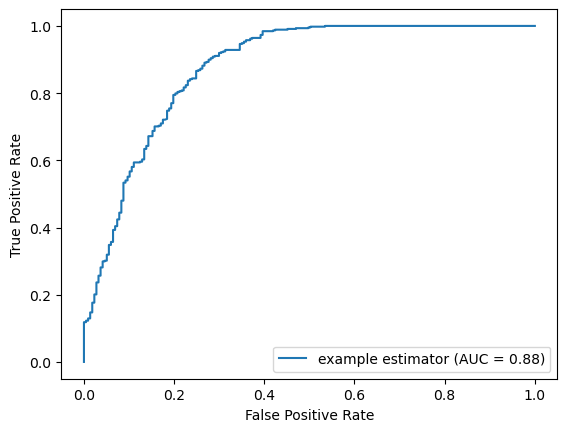

In [97]:
model = build_model(
        input_shape,
        head_size=64,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        out_dropout=0.8,
        dropout=0.4,
    )

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/transformer-3'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

Sensitivity: 0.7096774193548387 
Specificity: 0.9040178571428571 
PPV: 0.7817258883248731 
NPV: 0.8653846153846154 
Accuracy: 0.8406015037593985
[[154  63]
 [ 43 405]]


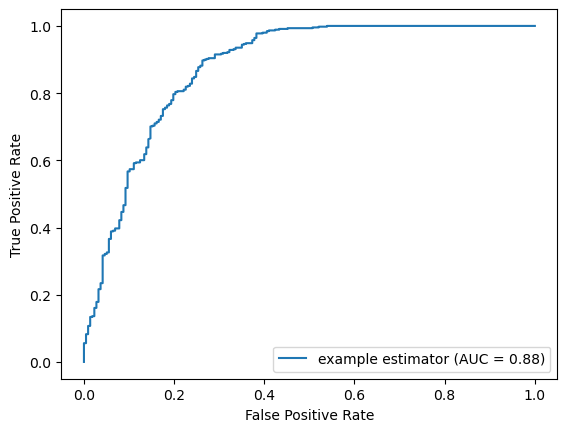

In [67]:
model = build_model(
        input_shape,
        head_size=32,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[16],
        mlp_dropout=0.8,
        dropout=0.2,
    )

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/transformer_aug-small'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

Sensitivity: 0.7419354838709677 
Specificity: 0.9017857142857143 
PPV: 0.7853658536585366 
NPV: 0.8782608695652174 
Accuracy: 0.849624060150376
[[161  56]
 [ 44 404]]


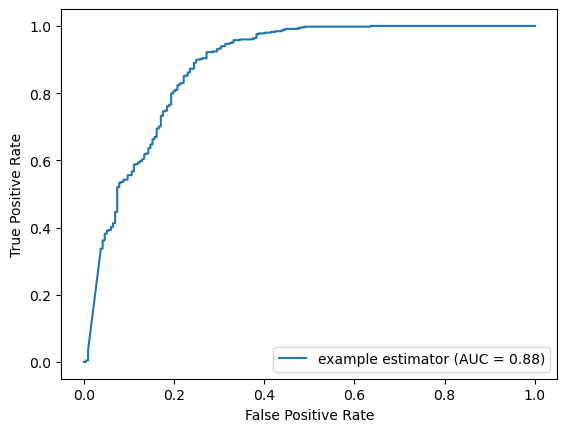

In [102]:
model = get_attn_lstm(200,64, 0.4,0.8)

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

Sensitivity: 0.7188940092165899 
Specificity: 0.9285714285714286 
PPV: 0.8297872340425532 
NPV: 0.8721174004192872 
Accuracy: 0.8601503759398497
[[156  61]
 [ 32 416]]


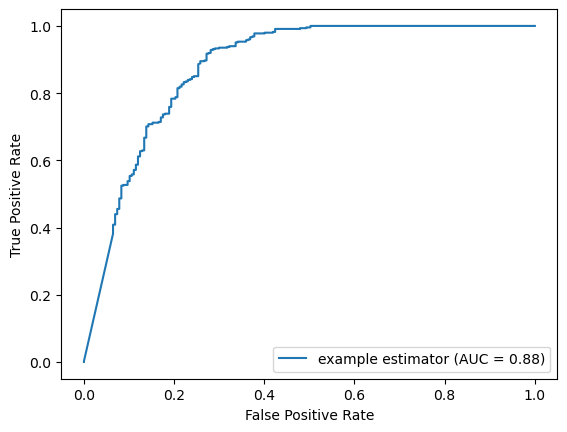

In [117]:
model = get_attn_lstm(200,64, 0.6, 0.9, [64,16], 32)

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-2'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

Sensitivity: 0.7649769585253456 
Specificity: 0.859375 
PPV: 0.7248908296943232 
NPV: 0.8830275229357798 
Accuracy: 0.8285714285714286
[[166  51]
 [ 63 385]]


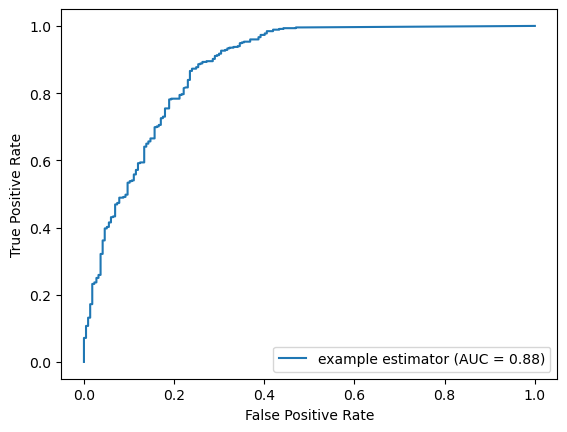

In [118]:
model = get_attn_lstm(200,64, 0.6,0.9, [64,16], attn=8)

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-3'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

Sensitivity: 0.783410138248848 
Specificity: 0.8058035714285714 
PPV: 0.6614785992217899 
NPV: 0.8848039215686274 
Accuracy: 0.7984962406015037
[[170  47]
 [ 87 361]]


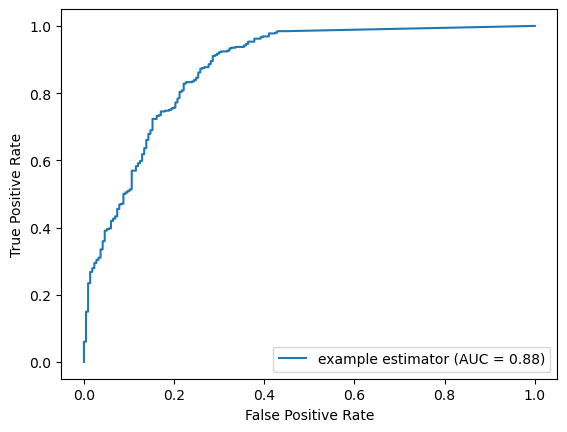

In [119]:
model = get_attn_lstm(200,64, 0.6,0.9, [64,16], lstm=32, attn=8)


checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/lstm-w-attn-4'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

Sensitivity: 0.7004608294930875 
Specificity: 0.9263392857142857 
PPV: 0.8216216216216217 
NPV: 0.8645833333333334 
Accuracy: 0.8526315789473684
[[152  65]
 [ 33 415]]


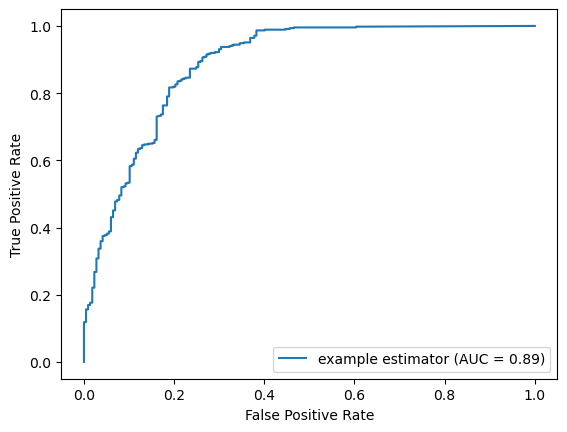

In [120]:
model = get_attn_gru(200,64, 0.6,0.9, [64,16], gru=32, attn=8)

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/gru-w-attn'

test_version(model, checkpoint_filepath, x_test, y_test, 'tot')

In [ ]:
test_ids['pred_results'] = np.round(y_pred_tot)

In [40]:
test_explote = pd.merge(test_ids, all_ids)

In [41]:
test_explote= test_explote.drop_duplicates(subset='StudyInstanceUID', keep='first')

In [42]:
true_pos = test_explote[(test_explote.negative_exam_for_pe == False) & (test_explote.pred_results ==False)]
false_pos = test_explote[(test_explote.negative_exam_for_pe == True) & (test_explote.pred_results ==False)]

true_neg = test_explote[(test_explote.negative_exam_for_pe == True) & (test_explote.pred_results ==True)]
false_neg = test_explote[(test_explote.negative_exam_for_pe == False) & (test_explote.pred_results ==True)]

In [43]:
true_pos.mean()

negative_exam_for_pe          0.000000
pred_results                  0.000000
pe_present_on_image           0.014815
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.007407
rv_lv_ratio_gte_1             0.451852
rv_lv_ratio_lt_1              0.548148
leftsided_pe                  0.814815
chronic_pe                    0.059259
true_filling_defect_not_pe    0.000000
rightsided_pe                 0.888889
acute_and_chronic_pe          0.066667
central_pe                    0.288889
indeterminate                 0.000000
contains_lung                 0.088889
dtype: float64

In [44]:
false_neg.mean()

negative_exam_for_pe          0.000000
pred_results                  1.000000
pe_present_on_image           0.000000
qa_motion                     0.000000
qa_contrast                   0.000000
flow_artifact                 0.073171
rv_lv_ratio_gte_1             0.182927
rv_lv_ratio_lt_1              0.817073
leftsided_pe                  0.548780
chronic_pe                    0.243902
true_filling_defect_not_pe    0.000000
rightsided_pe                 0.682927
acute_and_chronic_pe          0.097561
central_pe                    0.024390
indeterminate                 0.000000
contains_lung                 0.097561
dtype: float64

In [ ]:
test_explote[(test_explote.negative_exam_for_pe ==True) &
             (test_explote.true_filling_defect_not_pe == True)].pred_results.mean()

In [ ]:
test_explote[(test_explote.negative_exam_for_pe ==True) &
             (test_explote.true_filling_defect_not_pe == False)].pred_results.mean()

In [ ]:
false_pos.mean()

In [ ]:
true_neg.mean()

 0.6221198156682027 
 0.8839285714285714 
 0.7219251336898396 
 0.8284518828451883 
 0.7984962406015037
[[135  82]
 [ 52 396]]


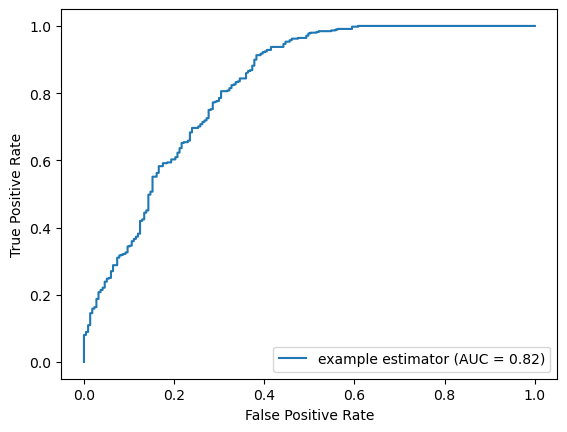

In [46]:
test_version(model, )

In [ ]:
y_test_seq = np.asarray(y_seq_test).flatten()
y_pred_seq = np.asarray(y_pred_seq).flatten()
cm = confusion_matrix(y_test_seq, y_pred_seq.round())

sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

ppv = cm[0][0]/(cm[0][0]+cm[1][0])
npv = cm[1][1]/(cm[1][1]+cm[0][1])

print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
print(cm)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tot, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
pred = model.predict(x)

In [ ]:
(131+153)/(131+71+50+153)

In [ ]:
from sklearn.metrics import confusion_matrix

# pred = pred - 0.03
cm = confusion_matrix(y, pred.round())
cm

In [ ]:
153/203

In [ ]:
cm[1,1]/(cm[1,0]+cm[1,1])

In [ ]:
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity, sensitivity

In [ ]:
y.sum()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()